<a href="https://colab.research.google.com/github/beingmechon/DataAnalysisWithPython/blob/main/Data_Analysis_GlobalTerrorismDatabase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Terrorism Data Analysis

## Description

The documentation in this Notebook thoroughly examines data on global terrorism obtained from Kaggle. The dataset contains comprehensive details about terrorist incidents around the world, allowing for a thorough investigation of trends, patterns, and a deeper understanding of global terrorism.

**Link to Kaggle Dataset:** [Global Terrorism Database](https://www.kaggle.com/START-UMD/gtd)

### Install required libs

In [ ]:
!pip install cartopy

## Download data

### Configure kaggle API authentication

Use your username and key from kaggle.

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [3]:
import json

username = "beingmechon"
key = "76892ed58057003b6e668fe9d589857a"

api_token = {"username": username,"key": key}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

### Download the data from kaggle and unzip

In [4]:
!kaggle datasets download -d START-UMD/gtd

 98% 28.0M/28.7M [00:00<00:00, 77.9MB/s]
100% 28.7M/28.7M [00:00<00:00, 72.7MB/s]


In [5]:
!unzip ../content/gtd.zip

Archive:  ../content/gtd.zip
  inflating: globalterrorismdb_0718dist.csv  


## Data Processing

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import numpy as np


In [7]:
dpi = 150
width = 1000 / dpi
height = 1000 / dpi

plt.rcParams['figure.figsize'] = (width, height)

def theme_custom():
    plt.rcParams.update({
        'axes.labelsize': 20,
        'axes.titlesize': 24,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.title_fontsize': 16,
        'legend.fontsize': 14
    })

def theme_custom_ts():
    plt.rcParams.update({
        'axes.labelsize': 18,
        'axes.titlesize': 18,
        'axes.titlepad': 15.0,
        'axes.titlelocation': 'left',
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold',
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 18,
        'legend.title_fontsize': 18,
        'legend.shadow': True,
        'legend.frameon': True,
        'legend.facecolor': 'white',
        'legend.edgecolor': 'black',
        'legend.fancybox': True,
        'legend.framealpha': 1,
        'legend.borderpad': 1
    })

def theme_custom_tiles():
    plt.rcParams.update({
        'axes.labelsize': 18,
        'axes.titlesize': 18,
        'axes.titlepad': 15.0,
        'axes.titlelocation': 'left',
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold',
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 18,
        'legend.title_fontsize': 18,
        'legend.shadow': True,
        'legend.frameon': True,
        'legend.facecolor': 'white',
        'legend.edgecolor': 'black',
        'legend.fancybox': True,
        'legend.framealpha': 1,
        'legend.borderpad': 1
    })


In [ ]:
df = pd.read_csv("../content/globalterrorismdb_0718dist.csv", encoding='latin-1')

dimensions = df.shape
print("Dimensions of the DataFrame:", dimensions)

In [9]:
# Selecting specific columns from the DataFrame
data = df[['iyear', 'imonth', 'iday', 'latitude', 'longitude',
           'nperps', 'nkill', 'nwound', 'nkillter', 'propextent',
           'ransomamt', 'doubtterr', 'vicinity', 'ishostkid', 'extended',
           'city', 'country', 'region', 'country_txt', 'region_txt',
           'attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'gname']]


In [10]:
# Renaming columns
data = data.rename(columns={'iyear': 'year',
                            'imonth': 'month',
                            'iday': 'day',
                            'propextent': 'damage',
                            'latitude': 'lat',
                            'longitude': 'long'})

# Mutating columns
data['country'] = data['country_txt']
data['region'] = data['region_txt']
data['attack'] = data['attacktype1_txt']
data['weapon'] = data['weaptype1_txt']
data['target'] = data['targtype1_txt']

# Selecting columns and dropping unwanted ones
data = data.drop(columns=['country_txt', 'region_txt', 'attacktype1_txt', 'weaptype1_txt', 'targtype1_txt'])


In [ ]:
data['attack'].unique()

In [11]:
# Convert 'attack' column to string
data['attack'] = data['attack'].astype(str)

# Replace values in the 'attack' column
data['attack'] = data['attack'].replace({
    'Facility/Infrastructure Attack': 'Infrastructure Attack',
    'Bombing/Explosion': 'Explosion',
    'Hostage Taking (Barricade Incident)': 'Hostage (Barricade)',
    'Hostage Taking (Kidnapping)': 'Hostage (Kidnapping)'
})

# Convert 'attack' column to categorical
data['attack'] = data['attack'].astype('category')


In [12]:
data['weapon'].unique()

array(['Unknown', 'Explosives', 'Incendiary', 'Firearms', 'Chemical',
       'Melee', 'Sabotage Equipment',
       'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'Fake Weapons', 'Radiological', 'Other', 'Biological'],
      dtype=object)

In [13]:
# Convert 'weapon' column to string
data['weapon'] = data['weapon'].astype(str)

# Replace values in the 'weapon' column
data['weapon'] = data['weapon'].replace(
    {'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)': 'Vehicle'}
)

# Convert 'weapon' column to categorical
data['weapon'] = data['weapon'].astype('category')


In [14]:
data['target'].unique()

array(['Private Citizens & Property', 'Government (Diplomatic)',
       'Journalists & Media', 'Police', 'Utilities', 'Military',
       'Government (General)', 'Airports & Aircraft', 'Business',
       'Educational Institution', 'Violent Political Party',
       'Religious Figures/Institutions', 'Unknown', 'Transportation',
       'Tourists', 'NGO', 'Telecommunication', 'Food or Water Supply',
       'Terrorists/Non-State Militia', 'Other', 'Maritime',
       'Abortion Related'], dtype=object)

In [15]:
# Convert 'target' column to string
data['target'] = data['target'].astype(str)

# Replace values in the 'target' column
data['target'] = data['target'].replace({
    'Government (General)': 'Government',
    'Private Citizens & Property': 'Private'
})

# Convert 'target' column to categorical
data['target'] = data['target'].astype('category')


In [ ]:
data['country'].unique()

In [17]:
# Convert 'country' column to string
data['country'] = data['country'].astype(str)

# Replace values in the 'country' column
data['country'] = data['country'].replace('Democratic Republic of the Congo', 'Congo')

# Convert 'country' column to categorical
data['country'] = data['country'].astype('category')


In [18]:
data['gname'].unique()

array(['MANO-D', '23rd of September Communist League', 'Unknown', ...,
       'Fatoni Warriors', 'Minorities of Metropolitan Attacks',
       'Baloch Republican Party'], dtype=object)

In [19]:
# Convert 'gname' column to string
data['gname'] = data['gname'].astype(str)

# Replace values in the 'gname' column
data['gname'] = data['gname'].replace({
    'Islamic State of Iraq and the Levant (ISIL)': 'ISIL',
    'Al-Qaida in Iraq': 'Al-Qaida',
    'Al-Nusrah Front': 'Al-Nusrah',
    'Fulani extremists': 'Fulani',
    'Houthi extremists (Ansar Allah)': 'Ansar Allah',
    'Communist Party of India - Maoist (CPI-Maoist)': 'CPI - Maoist',
    'Tehrik-i-Taliban Pakistan (TTP)': 'TTP'
})

# Convert 'gname' column to categorical
data['gname'] = data['gname'].astype('category')


In [20]:
rows, cols = data.shape
print("Number of rows:", rows)
print("Number of columns:", cols)


Number of rows: 181691
Number of columns: 22


In [21]:
data = data[(data['year'] >= 2007) & (data['year'] <= 2017) & (data['doubtterr'] == 0)]

In [22]:
rows, cols = data.shape
print("Number of rows:", rows)
print("Number of columns:", cols)


Number of rows: 83606
Number of columns: 22


### Process missing values

In [23]:
# Replace values less than 0 with 0 for specified columns
data['doubtterr'] = data['doubtterr'].apply(lambda x: 0 if x < 0 else x)
data['vicinity'] = data['vicinity'].apply(lambda x: 0 if x < 0 else x)
data['extended'] = data['extended'].apply(lambda x: 0 if x < 0 else x)
data['ishostkid'] = data['ishostkid'].apply(lambda x: 0 if x < 0 else x)


<ipython-input-23-6899cf74e0b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['doubtterr'] = data['doubtterr'].apply(lambda x: 0 if x < 0 else x)


In [24]:
# Replace values less than or equal to 0 with 1 for 'nperps'
data['nperps'] = data['nperps'].apply(lambda x: 1 if x <= 0 else x)

# Replace values less than 0 with 0 for 'nkill', 'nwound', 'nkillter', 'ransomamt', and 'damage'
data['nkill'] = data['nkill'].apply(lambda x: 0 if x < 0 else x)
data['nwound'] = data['nwound'].apply(lambda x: 0 if x < 0 else x)
data['nkillter'] = data['nkillter'].apply(lambda x: 0 if x < 0 else x)
data['ransomamt'] = data['ransomamt'].apply(lambda x: 0 if x < 0 else x)
data['damage'] = data['damage'].apply(lambda x: 0 if x < 0 else x)


In [25]:
# Replace missing values with specified values
data['doubtterr'].fillna(0, inplace=True)
data['vicinity'].fillna(0, inplace=True)
data['extended'].fillna(0, inplace=True)
data['ishostkid'].fillna(0, inplace=True)
data['nperps'].fillna(1, inplace=True)
data['nkill'].fillna(0, inplace=True)
data['nwound'].fillna(0, inplace=True)
data['nkillter'].fillna(0, inplace=True)
data['ransomamt'].fillna(0, inplace=True)
data['damage'].fillna(0, inplace=True)


### Convert data types & formats

In [26]:
# Convert 'nwound' column to integer
data['nwound'] = data['nwound'].astype(int)

# Convert other columns to boolean
data['doubtterr'] = data['doubtterr'].astype(bool)
data['vicinity'] = data['vicinity'].astype(bool)
data['extended'] = data['extended'].astype(bool)
data['ishostkid'] = data['ishostkid'].astype(bool)


In [27]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 83606 entries, 82108 to 181690
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   year       83606 non-null  int64   
 1   month      83606 non-null  int64   
 2   day        83606 non-null  int64   
 3   lat        83122 non-null  float64 
 4   long       83122 non-null  float64 
 5   nperps     83606 non-null  float64 
 6   nkill      83606 non-null  float64 
 7   nwound     83606 non-null  int64   
 8   nkillter   83606 non-null  float64 
 9   damage     83606 non-null  float64 
 10  ransomamt  83606 non-null  float64 
 11  doubtterr  83606 non-null  bool    
 12  vicinity   83606 non-null  bool    
 13  ishostkid  83606 non-null  bool    
 14  extended   83606 non-null  bool    
 15  city       83248 non-null  object  
 16  country    83606 non-null  category
 17  region     83606 non-null  object  
 18  gname      83606 non-null  category
 19  attack     83606 non

### Create required derived columns for analysis

In [28]:
# Replace month and day values where necessary
data['month'] = data['month'].apply(lambda x: 6 if x == 0 else x)
data['day'] = data['day'].apply(lambda x: 15 if x == 0 else x)

# Create a new 'date' column using pandas to_datetime
data['date'] = pd.to_datetime(data[['year', 'month', 'day']], errors='coerce')

# Remove rows with missing date values
data = data.dropna(subset=['date'])


In [29]:
rows, cols = data.shape
print("Number of rows:", rows)
print("Number of columns:", cols)


Number of rows: 83606
Number of columns: 23


### Encoding the 'damage' column based on severity

In [30]:
# Replace values in the 'damage' column
data['damage'] = data['damage'].replace({
    0: 'Unknown',
    4: 'Unknown',
    3: 'Low',
    2: 'Medium',
    1: 'High'
})

# Convert 'damage' column to categorical type
data['damage'] = data['damage'].astype('category')


## Data Exploration

### Dates & timestamps

In [31]:
min_date = data['date'].min()
max_date = data['date'].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)


Minimum date: 2007-01-01 00:00:00
Maximum date: 2017-12-31 00:00:00


### Categorical variables

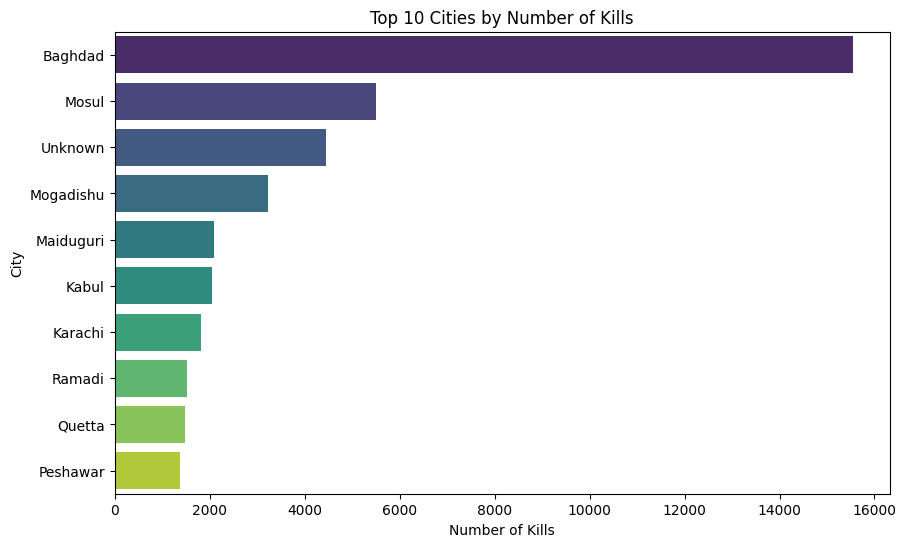

In [32]:
# Filter out rows where city is not empty
filtered_data_city = data[data['city'] != '']

# Group by city and calculate the sum of nkill
by_city = filtered_data_city.groupby('city')['nkill'].sum().reset_index()

# Select top 10 cities with highest nkill
top_cities = by_city.nlargest(10, 'nkill')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=top_cities, x='nkill', y='city', hue='city', palette='viridis', legend=False)
plt.xlabel('Number of Kills')
plt.ylabel('City')
plt.title('Top 10 Cities by Number of Kills')
plt.show()


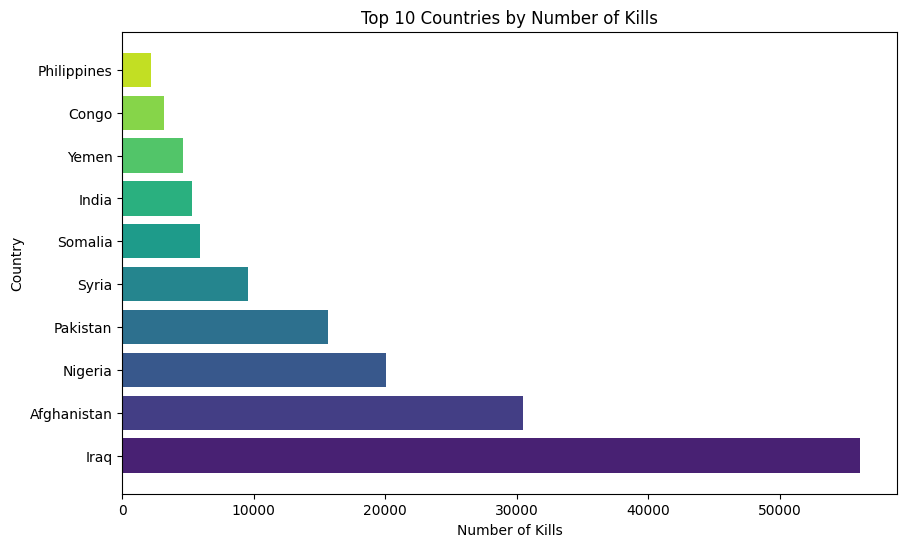

In [33]:
filtered_data_country = data[data['country'] != '']

# Group by country and calculate the sum of nkill
by_country = filtered_data_country.groupby('country')['nkill'].sum().reset_index()

# Select top 10 countries with highest nkill
top_countries = by_country.nlargest(10, 'nkill')

# Plotting
plt.figure(figsize=(10, 6))
# sns.barplot(data=top_countries, x='nkill', y='country', hue='country', palette='viridis', legend=False, dodge=False)
plt.barh(top_countries['country'], top_countries['nkill'], color=sns.color_palette('viridis', len(top_countries)))
plt.xlabel('Number of Kills')
plt.ylabel('Country')
plt.title('Top 10 Countries by Number of Kills')
plt.show()


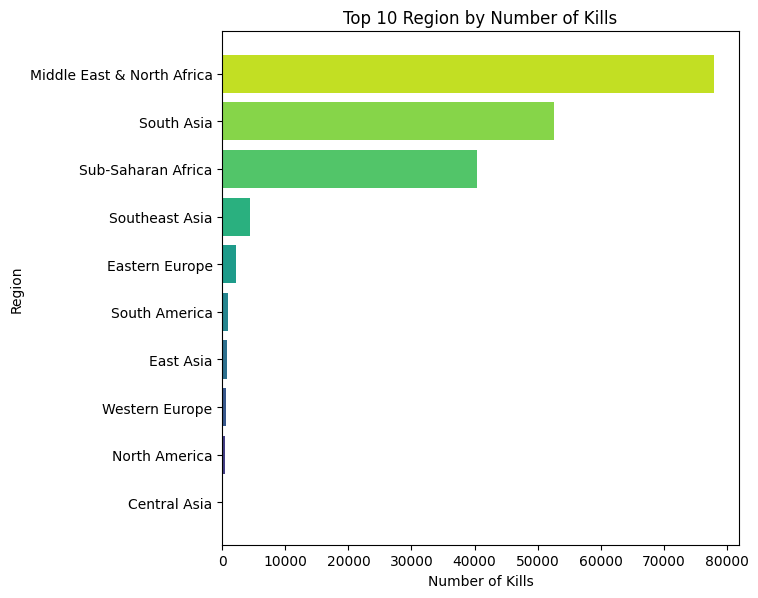

In [34]:
# Filter data where region is not blank
filtered_data_region = data[data['region'] != '']

# Groupby the data and sum with nkill
by_region = filtered_data_region.groupby('region')['nkill'].sum().reset_index()

# Get top 10 largest kill by region
top_region = by_region.nlargest(10, 'nkill').sort_values(by='nkill')

# Plot
plt.barh(top_region['region'], top_region['nkill'], color=sns.color_palette('viridis', len(top_region)))
plt.xlabel('Number of Kills')
plt.ylabel('Region')
plt.title('Top 10 Region by Number of Kills')
plt.show()


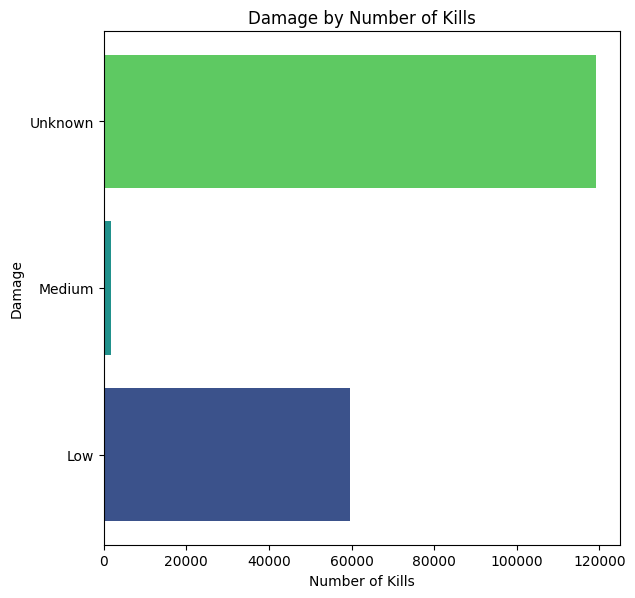

In [35]:
# Filter data where damage is not blank
filtered_data_damage = data[data['damage'] != '']

# Groupby the data and sum with nkill
by_damage = filtered_data_damage.groupby('damage')['nkill'].sum().reset_index()

# Plot
plt.barh(by_damage['damage'], by_damage['nkill'], color=sns.color_palette('viridis', len(by_damage)))
plt.xlabel('Number of Kills')
plt.ylabel('Damage')
plt.title('Damage by Number of Kills')
plt.show()


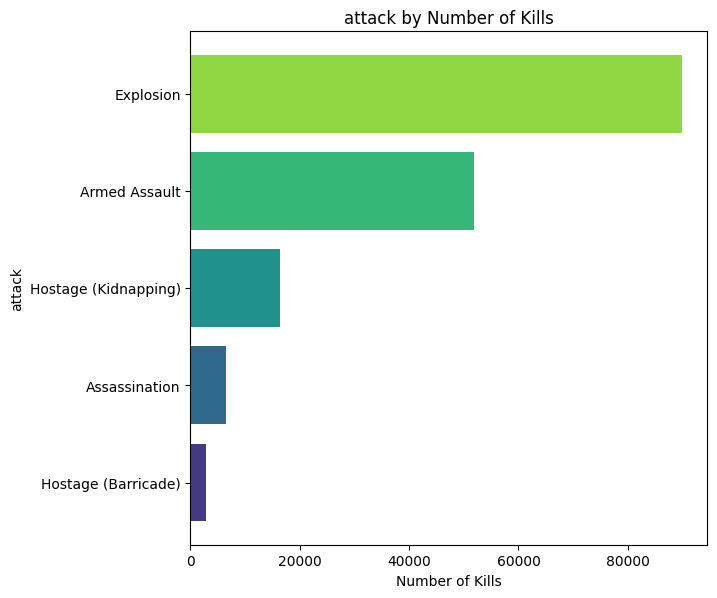

In [36]:
# Filter data where attack is not blank
filtered_data_attack = data[(data['attack'] != '') & (data['attack'] != 'Unknown')]

# Groupby the data and sum with nkill
by_attack = filtered_data_attack.groupby('attack')['nkill'].sum().reset_index().sort_values(by='nkill')

# Get top 10 largest kill by attack
top_attack = by_attack.nlargest(5, 'nkill').sort_values(by='nkill')

# Plot
plt.barh(top_attack['attack'], top_attack['nkill'], color=sns.color_palette('viridis', len(top_attack)))
plt.xlabel('Number of Kills')
plt.ylabel('attack')
plt.title('attack by Number of Kills')
plt.show()


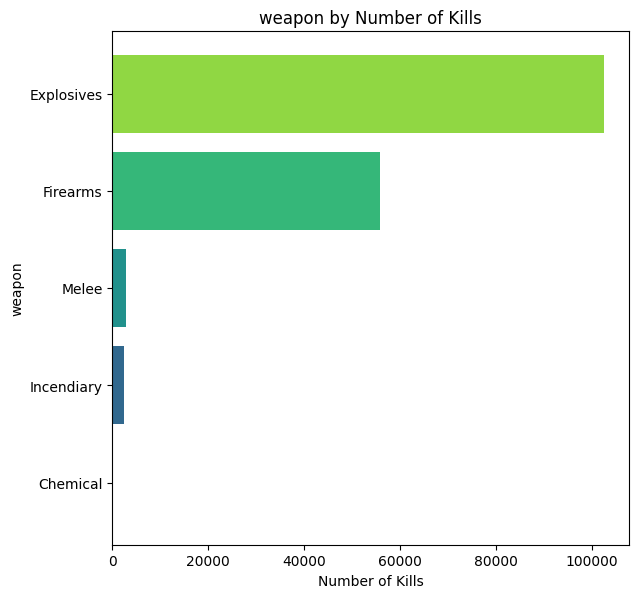

In [37]:
# Filter data where weapon is not blank
filtered_data_weapon = data[(data['weapon'] != '') & (data['weapon'] != 'Unknown')]

# Groupby the data and sum with nkill
by_weapon = filtered_data_weapon.groupby('weapon')['nkill'].sum().reset_index()

# Get top 10 largest kill by weapon
top_weapon = by_weapon.nlargest(5, 'nkill').sort_values(by='nkill')

# Plot
plt.barh(top_weapon['weapon'], top_weapon['nkill'], color=sns.color_palette('viridis', len(top_weapon)))
plt.xlabel('Number of Kills')
plt.ylabel('weapon')
plt.title('weapon by Number of Kills')
plt.show()


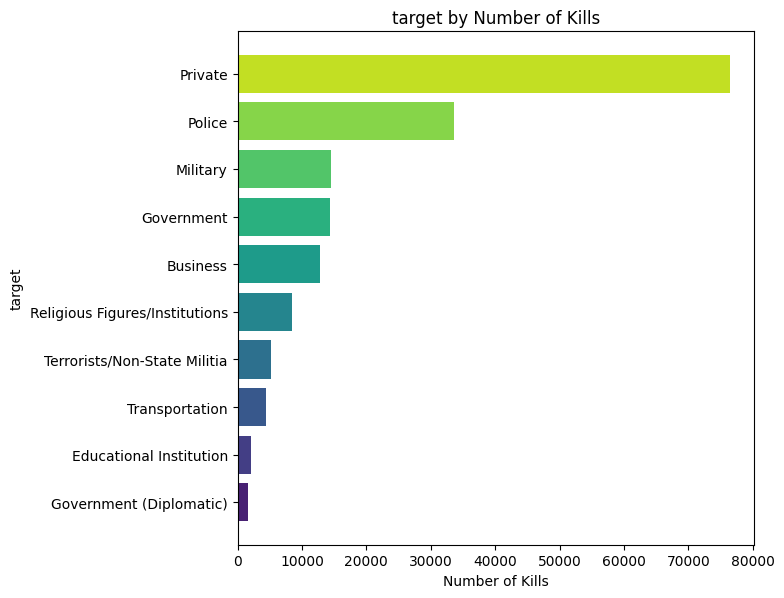

In [38]:
# Filter data where target is not blank
filtered_data_target = data[(data['target'] != '') & (data['target'] != 'Unknown')]

# Groupby the data and sum with nkill
by_target = filtered_data_target.groupby('target')['nkill'].sum().reset_index()

# Get top 10 largest kill by target
top_target = by_target.nlargest(10, 'nkill').sort_values(by='nkill')

# Plot
plt.barh(top_target['target'], top_target['nkill'], color=sns.color_palette('viridis', len(top_target)))
plt.xlabel('Number of Kills')
plt.ylabel('target')
plt.title('target by Number of Kills')
plt.show()


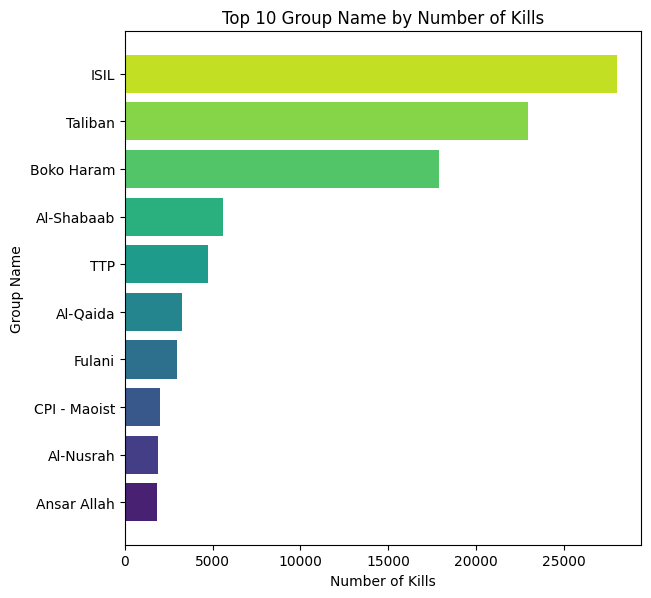

In [39]:
# Filter data where Group Name is not blank
filtered_data_gname = data[(data['gname'] != '') & (data['gname'] != 'Unknown')]


# Groupby the data and sum with nkill
by_gname = filtered_data_gname.groupby('gname')['nkill'].sum().reset_index()

# Get top 10 largest kill by Group Name
top_gname = by_gname.nlargest(10, 'nkill').sort_values(by='nkill')

# Plot
plt.barh(top_gname['gname'], top_gname['nkill'], color=sns.color_palette('viridis', len(top_gname)))
plt.xlabel('Number of Kills')
plt.ylabel('Group Name')
plt.title('Top 10 Group Name by Number of Kills')
plt.show()

In [40]:
# Get the top 5 active groups
most_active = by_gname['gname'].astype(str).tolist()[:5]

# Filter data for the top 5 active groups
filtered_data = data[data['gname'].isin(most_active)]
filtered_data

# Group by gname, country, and target, and summarize nkill
group_targets = filtered_data.groupby(['gname', 'country', 'target'])['nkill'].sum().reset_index()
# group_targets

# Group by gname and sort by descending nkill
group_targets = group_targets.sort_values(by=['gname', 'nkill'], ascending=[True, False]).groupby('gname').head(1).reset_index(drop=True)

# Display the resulting DataFrame
group_targets


,gname,country,target,nkill
0,1 May,Afghanistan,Abortion Related,0.0
1,14 K Triad,Afghanistan,Abortion Related,0.0
2,14 March Coalition,Afghanistan,Abortion Related,0.0
3,14th of December Command,Afghanistan,Abortion Related,0.0
4,15th of September Liberation Legion,Afghanistan,Abortion Related,0.0
...,...,...,...,...
3530,Zulu Miners,Afghanistan,Abortion Related,0.0
3531,Zuwar al-Imam Rida,Afghanistan,Abortion Related,0.0
3532,Zviadists,Afghanistan,Abortion Related,0.0
3533,Zwai Tribe,Afghanistan,Abortion Related,0.0


### Numerical variables

#### Descriptive statistics

In [41]:
numerical = [
    "nperps",
    "nkill",
    "nwound",
    "nkillter",
    "ransomamt"
]


In [42]:
numerical_variables = data[numerical]
summary_statistics = numerical_variables.describe()

print(summary_statistics)


             nperps         nkill        nwound      nkillter     ransomamt
count  83606.000000  83606.000000  83606.000000  83606.000000  8.360600e+04
mean       3.140110      2.157369      3.211935      0.377138  1.745664e+04
std       32.115118      9.305405     14.075106      3.226812  1.340889e+06
min        1.000000      0.000000      0.000000      0.000000  0.000000e+00
25%        1.000000      0.000000      0.000000      0.000000  0.000000e+00
50%        1.000000      0.000000      0.000000      0.000000  0.000000e+00
75%        1.000000      2.000000      3.000000      0.000000  0.000000e+00
max     5000.000000    953.000000   1500.000000    301.000000  2.000000e+08


In [43]:
len(data['date'])

83606

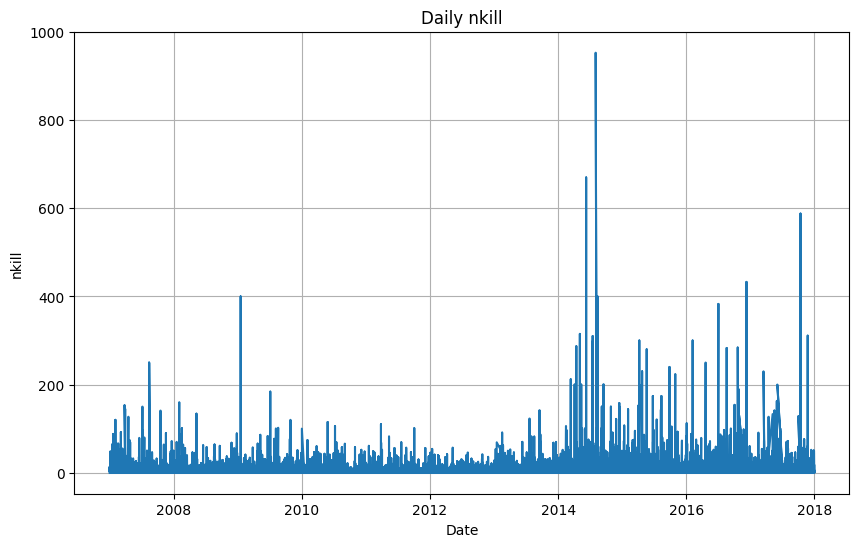

In [44]:
# Fill missing values in 'nkill' column with 0
data['nkill'].fillna(0, inplace=True)

# Replace negative 'nkill' values with 0
data['nkill'] = data['nkill'].apply(lambda x: max(x, 0))

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if necessary
plt.plot(data['date'], data['nkill'])
plt.xlabel('Date')
plt.ylabel('nkill')
plt.title('Daily nkill')
plt.grid(True)
plt.show()


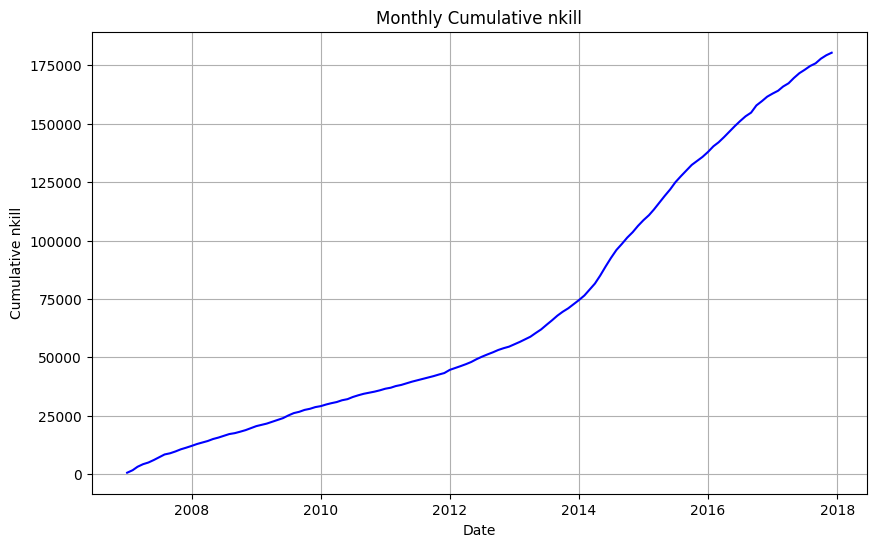

In [45]:
# Fill missing values in 'nkill' column with 0
data['nkill'].fillna(0, inplace=True)

# Replace negative 'nkill' values with 0
data['nkill'] = data['nkill'].apply(lambda x: max(x, 0))

# Group by year and month, summing up nkill for each group
nkill_monthly = data.groupby(['year', 'month'])['nkill'].sum().reset_index()

# Create a date column using the year and month values
nkill_monthly['date'] = pd.to_datetime(nkill_monthly[['year', 'month']].assign(day=1))

# Calculate cumulative sum of nkill
nkill_monthly['nkill'] = nkill_monthly['nkill'].cumsum()

# Drop year and month columns
nkill_monthly.drop(columns=['year', 'month'], inplace=True)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if necessary
plt.plot(nkill_monthly['date'], nkill_monthly['nkill'], color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative nkill')
plt.title('Monthly Cumulative nkill')
plt.grid(True)
plt.show()


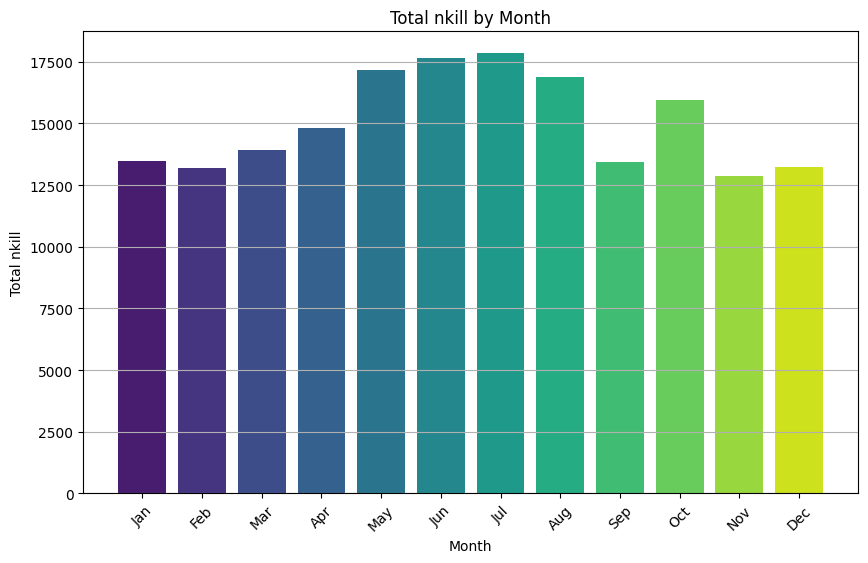

In [46]:
# Group by month and calculate the sum of nkill for each month
by_month = data.groupby('month')['nkill'].sum().reset_index()

# Map month numbers to month names
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
by_month['monthname'] = by_month['month'].map(month_names)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if necessary
plt.bar(by_month['monthname'], by_month['nkill'], color=sns.color_palette('viridis', len(by_month)))
plt.xlabel('Month')
plt.ylabel('Total nkill')
plt.title('Total nkill by Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Add grid lines to y-axis
plt.show()


In [47]:
# sns.set_theme(style="darkgrid")
# sns.lineplot(data=nkill_by_weapon_monthly[["weapon", "nkill", "date"]], x='date', y='nkill', hue='weapon')
# plt.suptitle('Deaths by type of weapon over time', y=1.02)
# plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
# plt.tight_layout()
# plt.show()

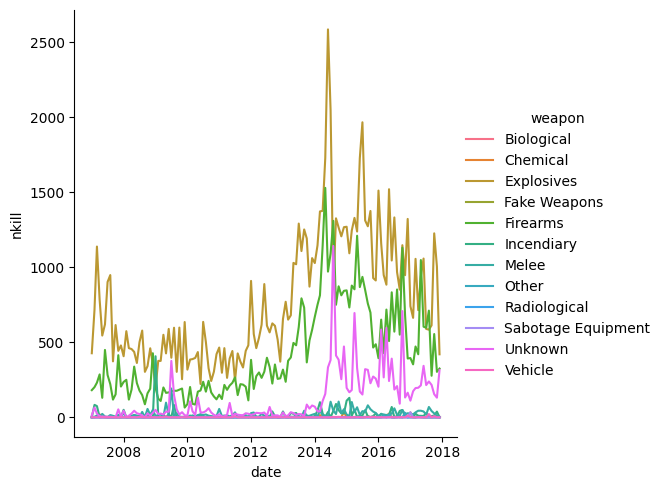

In [48]:
# Filter the data for selected weapons
selected_weapons = by_weapon['weapon']
nkill_by_weapon_monthly = data[data['weapon'].isin(selected_weapons)]

# Group by year, month, and weapon, and calculate the sum of nkill
nkill_by_weapon_monthly = nkill_by_weapon_monthly.groupby(['year', 'month', 'weapon'])['nkill'].sum().reset_index()

# Convert year and month to date format
nkill_by_weapon_monthly['date'] = pd.to_datetime(nkill_by_weapon_monthly[['year', 'month']].assign(day=1))

# sns.relplot(data=nkill_by_weapon_monthly[["weapon", "nkill", "date"]], x='date', y='nkill', hue='weapon')
sns.relplot(data=nkill_by_weapon_monthly, x='date', y='nkill', kind='line',
                             hue='weapon',) #  col='weapon', col_wrap=3


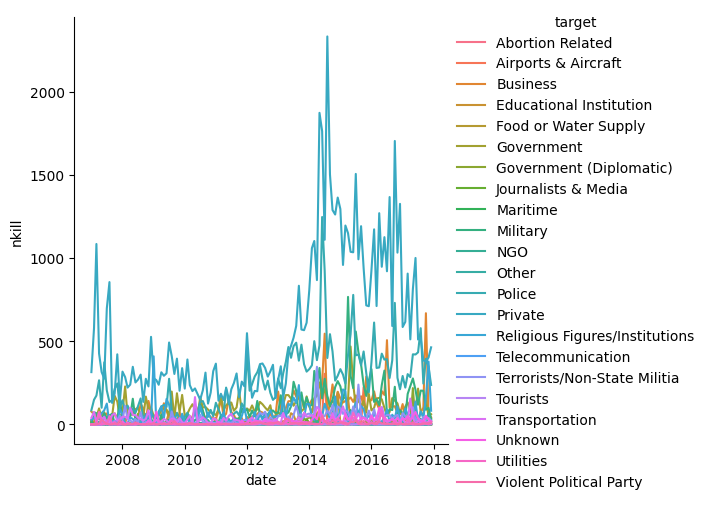

In [49]:
# Filter the data for selected target
selected_target = by_target['target']
nkill_by_target_monthly = data[data['target'].isin(selected_target)]

# Group by year, month, and target, and calculate the sum of nkill
nkill_by_target_monthly = nkill_by_target_monthly.groupby(['year', 'month', 'target'])['nkill'].sum().reset_index()

# Convert year and month to date format
nkill_by_target_monthly['date'] = pd.to_datetime(nkill_by_target_monthly[['year', 'month']].assign(day=1))

sns.relplot(data=nkill_by_target_monthly, x='date', y='nkill', kind='line',
                             hue='target',) #  col='target', col_wrap=5


In [50]:
nkill_by_target_monthly[['target', 'nkill', 'date']].groupby('target').sum(numeric_only=True).sort_values('nkill', ascending=False).nlargest(10, 'nkill').index

CategoricalIndex(['Private', 'Police', 'Military', 'Government', 'Business',
                  'Religious Figures/Institutions',
                  'Terrorists/Non-State Militia', 'Transportation', 'Unknown',
                  'Educational Institution'],
                 categories=['Abortion Related', 'Airports & Aircraft', 'Business', 'Educational Institution', ..., 'Transportation', 'Unknown', 'Utilities', 'Violent Political Party'], ordered=False, dtype='category', name='target')

#### Correlation

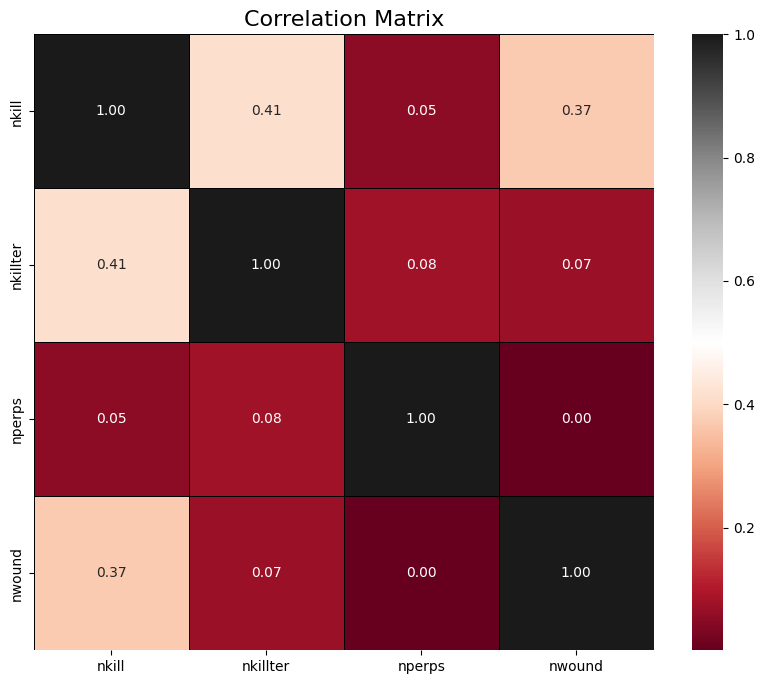

In [51]:
C = data[['nkill', 'nkillter', 'nperps', 'nwound']].dropna()

# Calculate the correlation matrix
correlation_matrix = C.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='RdGy', fmt=".2f", linewidths=0.5, linecolor='black')
heatmap.set_title('Correlation Matrix', size=16)
plt.show()


#### Binary columns

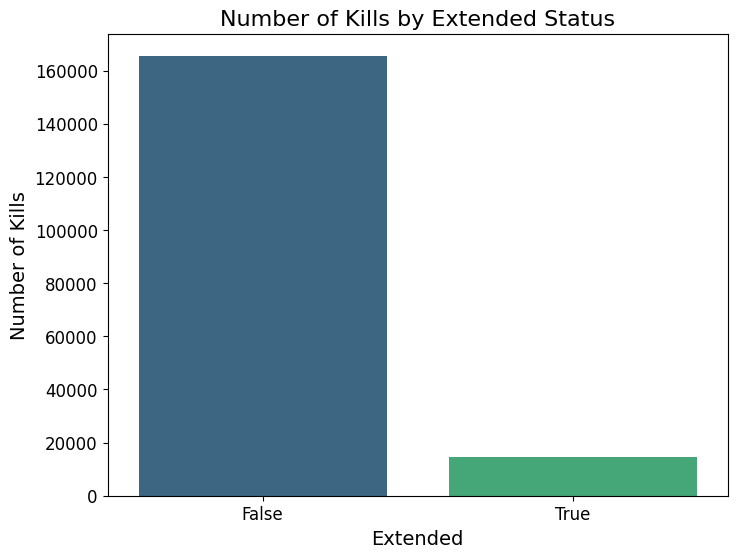

In [52]:
# Group by 'extended' column and calculate the sum of 'nkill' for each group
by_extended = data.groupby('extended')['nkill'].sum().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(data=by_extended, x='extended', y='nkill', hue='extended', palette='viridis', legend=False)
plt.xlabel('Extended', fontsize=14)
plt.ylabel('Number of Kills', fontsize=14)
plt.title('Number of Kills by Extended Status', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


<ipython-input-53-6fec2dac3ee0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_ishostkid, x='ishostkid', y='nkill', palette='viridis')


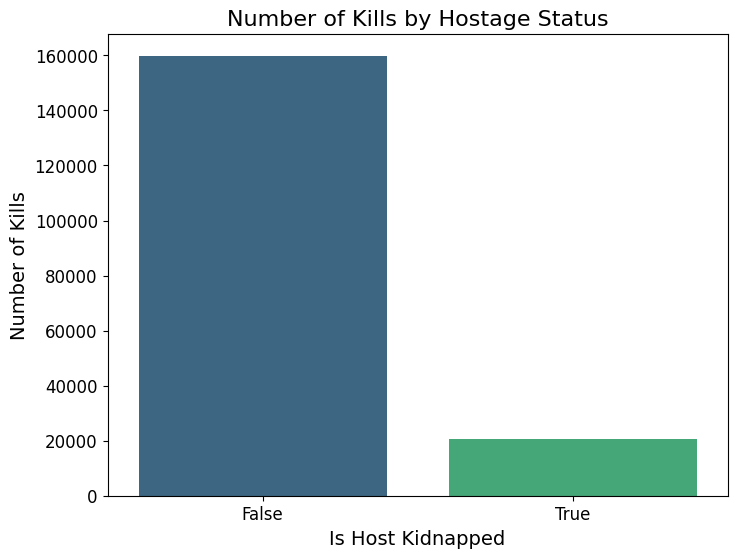

In [53]:
# Group by 'ishostkid' column and calculate sum of 'nkill' for each group
by_ishostkid = data.groupby('ishostkid')['nkill'].sum().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(data=by_ishostkid, x='ishostkid', y='nkill', palette='viridis')
plt.xlabel('Is Host Kidnapped', fontsize=14)
plt.ylabel('Number of Kills', fontsize=14)
plt.title('Number of Kills by Hostage Status', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


<ipython-input-54-d6fff30f64ea>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_vicinity, x='vicinity', y='nkill', palette='viridis')


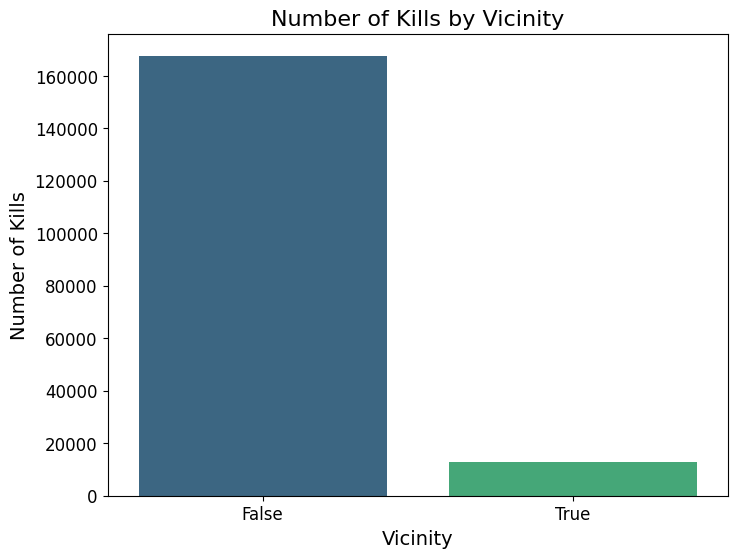

In [54]:
# Group by 'vicinity' column and calculate sum of 'nkill' for each group
by_vicinity = data.groupby('vicinity')['nkill'].sum().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(data=by_vicinity, x='vicinity', y='nkill', palette='viridis')
plt.xlabel('Vicinity', fontsize=14)
plt.ylabel('Number of Kills', fontsize=14)
plt.title('Number of Kills by Vicinity', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## Geospatial variables

In [55]:
# Get the top 5 most active groups
most_active = data['gname'].value_counts().index[:5]

# Filter data for the top 5 most active groups
attacks = data[data['gname'].isin(most_active)]

# Select relevant columns
attacks = attacks[['year', 'month', 'day', 'lat', 'long', 'gname', 'country', 'nkill']]

# Remove rows with missing latitude or longitude values
attacks = attacks.dropna(subset=['lat', 'long'])


In [56]:
# Group by 'gname' and 'country', summarize 'nkill', and calculate mean latitude and longitude
location = attacks.groupby(['gname', 'country']).agg(
    nkill=('nkill', 'sum'),
    lat=('lat', 'mean'),
    long=('long', 'mean')
).reset_index()

# Group by 'gname', arrange by descending 'nkill', and summarize other variables
location = location.groupby('gname').apply(lambda x: x.sort_values('nkill', ascending=False).head(1)).reset_index(drop=True)

# Rename 'gname' values for better readability
location['full_gname'] = location['gname'].replace({
    'ISIL': 'Islamic State of Iraq and the Levant',
    'TTP': 'Tehrik-i-Taliban Pakistan'
})

# Create a new column combining 'full_gname' and 'country' for better labeling
location['full_gname_ctry'] = location['full_gname'].astype(str) + ', ' + location['country'].astype(str)


In [57]:
location

,gname,country,nkill,lat,long,full_gname,full_gname_ctry
0,1 May,Afghanistan,0.0,NaN,NaN,1 May,"1 May, Afghanistan"
1,14 K Triad,Afghanistan,0.0,NaN,NaN,14 K Triad,"14 K Triad, Afghanistan"
2,14 March Coalition,Afghanistan,0.0,NaN,NaN,14 March Coalition,"14 March Coalition, Afghanistan"
3,14th of December Command,Afghanistan,0.0,NaN,NaN,14th of December Command,"14th of December Command, Afghanistan"
4,15th of September Liberation Legion,Afghanistan,0.0,NaN,NaN,15th of September Liberation Legion,"15th of September Liberation Legion, Afghanistan"
...,...,...,...,...,...,...,...
3530,Zulu Miners,Afghanistan,0.0,NaN,NaN,Zulu Miners,"Zulu Miners, Afghanistan"
3531,Zuwar al-Imam Rida,Afghanistan,0.0,NaN,NaN,Zuwar al-Imam Rida,"Zuwar al-Imam Rida, Afghanistan"
3532,Zviadists,Afghanistan,0.0,NaN,NaN,Zviadists,"Zviadists, Afghanistan"
3533,Zwai Tribe,Afghanistan,0.0,NaN,NaN,Zwai Tribe,"Zwai Tribe, Afghanistan"


<ipython-input-58-589346e30a14>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


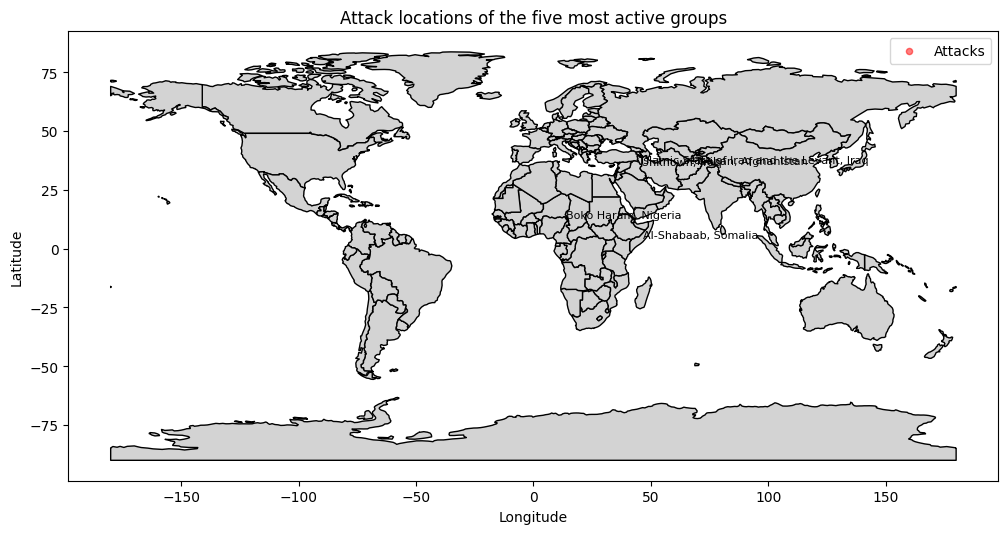

In [58]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the attacks for the five most active groups
most_active_groups = by_gname['gname'].head(5).tolist()
attacks_filtered = attacks[attacks['gname'].isin(most_active_groups)]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the world map
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the attack locations
attacks_filtered.plot(ax=ax, kind='scatter', x='long', y='lat', color='red', alpha=0.5, s=20, label='Attacks')

# Annotate the points
for x, y, label in zip(location['long'], location['lat'], location['full_gname_ctry']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

ax.set_title("Attack locations of the five most active groups")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# plt.savefig("group_attack_annotated_blue_sea.png", dpi=75)
plt.show()


In [59]:
import pandas as pd
import numpy as np

# Filter data for specific weapons
filtered_data = data[~data['weapon'].isin(["Fake Weapons", "Biological", "Radiological"])]

# Group by region and weapon
grouped_data = filtered_data.groupby(['region', 'weapon']).size().reset_index(name='count')

# Add a column for log count and label
grouped_data['logcount'] = np.log(grouped_data['count'])
grouped_data['label'] = grouped_data['count'].apply(lambda x: f"{round(x / 1000, 2)}K" if x > 1000 else x)

# Display the resulting DataFrame
grouped_data


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,region,weapon,count,logcount,label
0,Australasia & Oceania,Biological,0,-inf,0
1,Australasia & Oceania,Chemical,4,1.386294,4
2,Australasia & Oceania,Explosives,5,1.609438,5
3,Australasia & Oceania,Fake Weapons,0,-inf,0
4,Australasia & Oceania,Firearms,6,1.791759,6
...,...,...,...,...,...
139,Western Europe,Other,9,2.197225,9
140,Western Europe,Radiological,0,-inf,0
141,Western Europe,Sabotage Equipment,5,1.609438,5
142,Western Europe,Unknown,31,3.433987,31


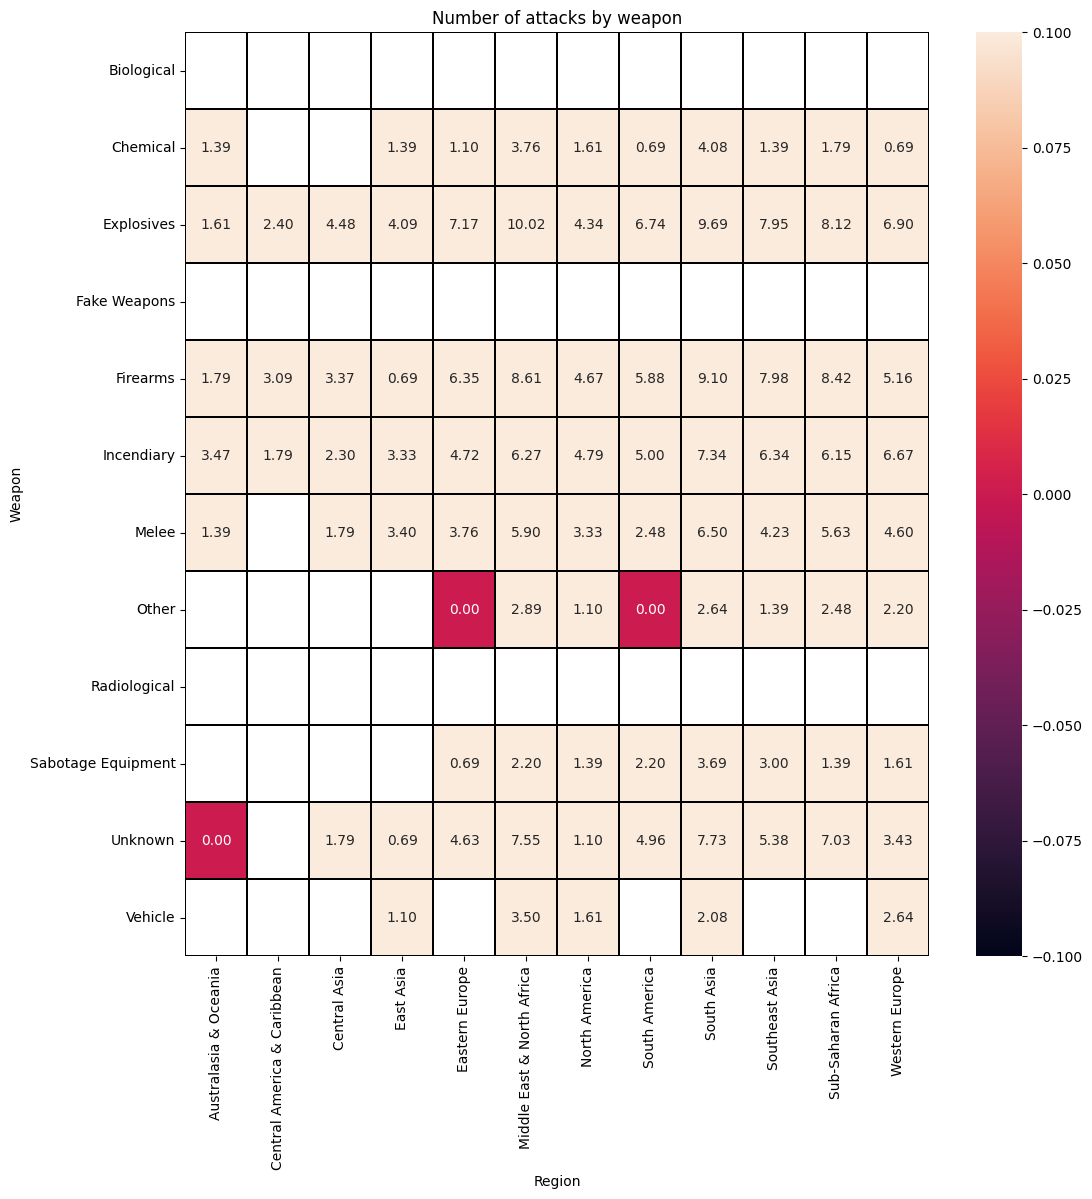

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot size
plt.figure(figsize=(12, 12))

# Create the tile plot
plot_weapon_tile = sns.heatmap(data=grouped_data.pivot(index='weapon', columns='region', values='logcount'),
                               annot=True, fmt=".2f", linewidths=0.1, linecolor='black') # cmap="RdGy",

# Set plot title
plt.title("Number of attacks by weapon")

# Set axis labels
plt.xlabel("Region")
plt.ylabel("Weapon")

# Save the plot
# plt.savefig("img/attacks_by_weapon.png", dpi=75)

# Show the plot
plt.show()


In [ ]:
# Generate date sequence
date = pd.date_range(start='2007-01-01', end='2017-12-31', freq='M')
date = pd.DataFrame({'date': date})

# Define the five most active groups
most_active = by_gname.nlargest(5, 'nkill').sort_values(by='nkill', ascending=False).gname.to_list()
print(most_active)

# Create a DataFrame with date and groups
groups = pd.DataFrame({'gname': most_active})

# Create combinations of date and groups
date['key'] = 0
groups['key'] = 0
date_groups = pd.merge(date, groups, on='key').drop('key', axis=1)
# date_groups

# Calculate total fatalities over time
nkill_total = data[data['gname'].isin(most_active)]
nkill_total['date'] = pd.to_datetime(nkill_total[['year', 'month']].assign(day=1))
nkill_total = nkill_total.groupby('date')['nkill'].sum().reset_index()

# Calculate fatalities per group over time
nkill_group = data[data['gname'].isin(most_active)] \
    .assign(date=pd.to_datetime(data[['year', 'month']].assign(day=1))) \
    .groupby(['date', 'gname'])['nkill'].sum().reset_index()

nkill_group = nkill_group[nkill_group['gname'].isin(most_active)]

# Merge total and group fatalities
nkill_over_time = pd.merge(nkill_total, nkill_group, on=['date'], how='left')
nkill_over_time['nkill_y'] = nkill_over_time['nkill_y'].fillna(0)

# Calculate percentage
nkill_over_time['pct'] = (nkill_over_time['nkill_y'] / nkill_over_time['nkill_x']) * 100

# Create the fancy time series plot
plt.figure(figsize=(12, 8))
plot_fancy_ts = sns.lineplot(data=nkill_over_time, x='date', y='pct', hue='gname', palette='Dark2', errorbar=None)
plt.title('Fatality distribution among the five most active groups')
plt.xlabel('Date')
plt.ylabel('Deaths (%)')
plt.ylim(0, 100)
plt.legend(title='Group')
plt.grid(False)
plt.tight_layout()

# Save the plot
# plt.savefig("img/top_five_groups_percent_ts.png", dpi=150)

# Show the plot
plt.show()
